In [ ]:
!pip install down

  Preparing metadata (setup.py) ... done
  Created wheel for down: filename=down-1.0-py3-none-any.whl size=2491 sha256=402f1cb462766d9418329765f0c423166c0927d9426047101cca849b776a8cdb
  Stored in directory: /root/.cache/pip/wheels/23/65/03/0d71416f3d1a58dc20588add6661be9a664261cc095fb3f4b5
Successfully built down


In [ ]:
import kagglehub

In [ ]:
path = kagglehub.dataset_download("adityajn105/flickr30k")

100%|██████████| 8.16G/8.16G [01:40<00:00, 87.1MB/s]

Extracting files...


In [ ]:
print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/adityajn105/flickr30k/versions/1


In [ ]:
!pip -q install sentence-transformers
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 49.7 MB/s eta 0:00:00


In [ ]:
import os
from glob import glob
from PIL import Image
import numpy as np
import faiss
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import random


<function matplotlib.pyplot.show(close=None, block=None)>

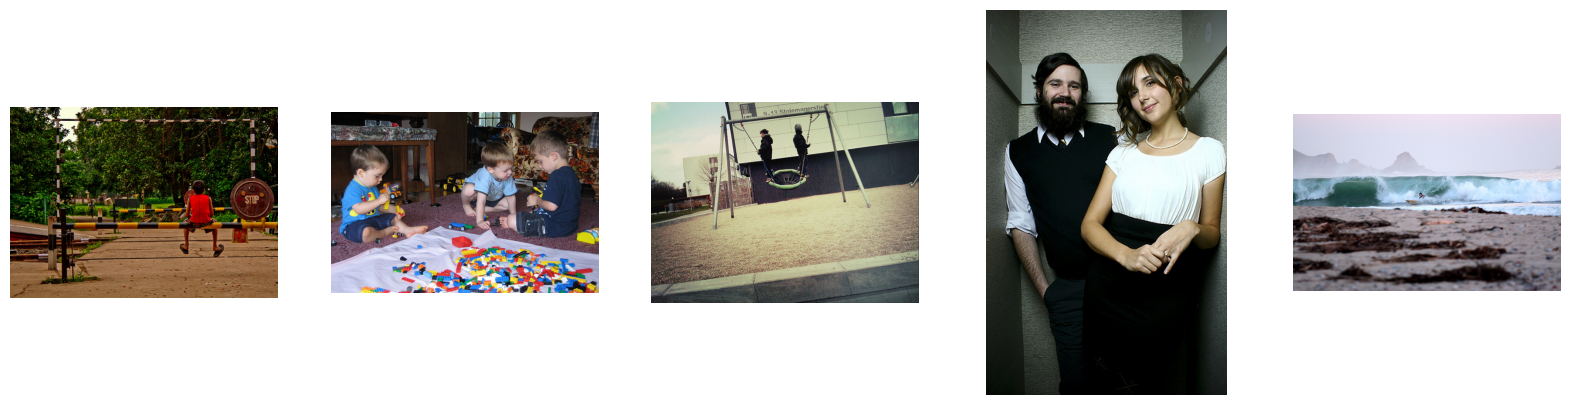

In [ ]:
image_folder ="/root/.cache/kagglehub/datasets/adityajn105/flickr30k/versions/1/Images"

# Lấy dan sác fil tron thư mục hìn ảnj
image_files = glob(os.path.join(image_folder, "*.jpg"))

# Chọn ngẫu nhiên 5 file hình ảnh
selected_images = random.sample(image_files, 5)

plt.figure(figsize=(20,5))

for i, fil in enumerate(selected_images):
  img = Image.open(fil)
  plt.subplot(1,5,i+1)
  plt.imshow(img)
  plt.axis("off")
plt.show

In [ ]:
# Tạo embeddin co 30K ảnh bằn model
model = SentenceTransformer("clip-ViT-B-32")
image_path = "/root/.cache/kagglehub/datasets/adityajn105/flickr30k/versions/1/Images"

image_files = glob(os.path.join(image_path, "*.jpg"))
chunk_size = 256

image_embeddings = []

def process_chunk(chunk):
  images = []
  for image_files in chunk:
    images.append(Image.open(image_files))
  embeddings = model.encode(images)
  return embeddings

for i in range(0, len(image_files), chunk_size):
  print(i)
  chunk = image_files[i:i+chunk_size]
  embeddings = process_chunk(chunk)
  image_embeddings.extend(embeddings)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.91k [00:00<?, ?B/s]

0_CLIPModel%2Fspecial_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

0_CLIPModel%2Fmerges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

0_CLIPModel%2Fvocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

0_CLIPModel%2Fpreprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

0_CLIPModel%2Fconfig.json:   0%|          | 0.00/4.03k [00:00<?, ?B/s]

0_CLIPModel%2Ftokenizer_config.json:   0%|          | 0.00/604 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

0
256
512
768
1024
1280
1536
1792
2048
2304
2560
2816
3072
3328
3584
3840
4096
4352
4608
4864
5120
5376
5632
5888
6144
6400
6656
6912
7168
7424
7680
7936
8192
8448
8704
8960
9216
9472
9728
9984
10240
10496
10752
11008
11264
11520
11776
12032
12288
12544
12800
13056
13312
13568
13824
14080
14336
14592
14848
15104
15360
15616
15872
16128
16384
16640
16896
17152
17408
17664
17920
18176
18432
18688
18944
19200
19456
19712
19968
20224
20480
20736
20992
21248
21504
21760
22016
22272
22528
22784
23040
23296
23552
23808
24064
24320
24576
24832
25088
25344
25600
25856
26112
26368
26624
26880
27136
27392
27648
27904
28160
28416
28672
28928
29184
29440
29696
29952
30208
30464
30720
30976
31232
31488
31744


In [ ]:
# Dựng lên vectorDB với FAISS
dimension = len(image_embeddings[0])
index = faiss.IndexFlatIP(dimension)
index = faiss.IndexIDMap(index)

vectors = np.array(image_embeddings).astype('float32')
index.add_with_ids(vectors, np.array(range(len(image_embeddings))))

# Save index vào file
faiss.write_index(index, "image_embeddings.faiss")

# Ghi các tên ảnh vào tệp tin để load khi cần
with open("image_files.txt", "w") as f:
  for image_file in image_files:
    f.write(image_file + "\n")

In [ ]:
def search_image(query, model, index, image_files, top_k=5):
  # Query có thể là ảnh hoặc text

  if query.endswith(".jpg"):
    query = Image.open(query)

  query_embedding = model.encode(query)
  query_embedding = query_embedding.astype("float32").reshape(1, -1)

  distances, indices = index.search(query_embedding, top_k)

  retrieved_image_files = [image_files[i] for i in indices[0]]
  return query, retrieved_image_files

In [ ]:
# Tìm kiếm từ text
query = "a red ball"
query, retrieved_image_files = search_image(query, model, index, image_files)

In [ ]:
# Visualize retrieved_image_files
def visualize_results(query, retrieved_images):
    plt.figure(figsize=(12, 5))

    # If image query
    if isinstance(query, Image.Image):
        plt.subplot(1, len(retrieved_images) + 1, 1)
        plt.imshow(query)
        plt.title("Query Image")
        plt.axis('off')
        start_idx = 2

    # If text query
    else:
        plt.subplot(1, len(retrieved_images) + 1, 1)
        plt.text(0.5, 0.5, f"Query:\n\n '{query}'", fontsize=16, ha='center', va='center')
        plt.axis('off')
        start_idx = 2

    # Display images
    for i, img_path in enumerate(retrieved_images):

        plt.subplot(1, len(retrieved_images) + 1, i + start_idx)
        plt.imshow(Image.open(img_path))
        plt.title(f"Match {i + 1}")
        plt.axis('off')

    plt.show()



In [ ]:
# Tìm kiếm từ text
query = "a book is on the table"#"a red motorbike and a green field"
query, retrieved_image_files = search_image(query, model, index, image_files)

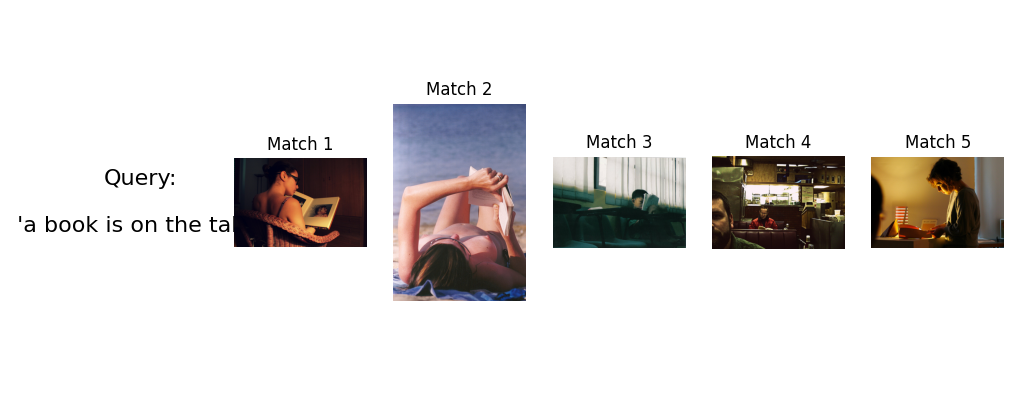

In [ ]:
visualize_results(query, retrieved_image_files)